In [1]:
import numpy as np
import torch

In [2]:
#define some useful functions
def generate_HMM_params(num_hidden_state, num_obs):
    # random generate the transition matrix and observation matrix, and compute the stationary distribution
    
    alpha_state = np.ones(num_hidden_state)
    alpha_obs = np.ones(num_obs) / num_obs
    trans_mat = np.random.dirichlet(alpha_state, num_hidden_state)
    obs_mat = np.random.dirichlet(alpha_obs, num_hidden_state)
    tmp = np.ones((num_hidden_state + 1, num_hidden_state))
    tmp[:-1] = np.identity(num_hidden_state) - trans_mat.T
    tmp_v = np.zeros(num_hidden_state + 1)
    tmp_v[-1] = 1
    stat_dist = np.linalg.lstsq(tmp, tmp_v, rcond=None)[0]
    return trans_mat, obs_mat, stat_dist

In [3]:
def generate_HMM_sequences(trans_mat, obs_mat, init_dist, length, num_samples = 1):
    # generate sample sequences from HMM
    
    states = np.zeros((num_samples, length))
    obs = np.zeros((num_samples, length))
    tmp_state = np.argmax(np.random.multinomial(1, init_dist, num_samples), axis = 1)
    #print(tmp_state)
    for i in range(length):
        #print("i: ", i)
        states[:, i] = tmp_state
        for j in range(num_samples):
            obs[j, i] = np.random.multinomial(1, obs_mat[tmp_state[j]]).argmax()
            tmp_state[j] = np.random.multinomial(1, trans_mat[tmp_state[j]]).argmax()
        #print("obs[:, i]: ", obs[:, i])
    return states, obs

In [4]:
def forward_compute(trans_mat, obs_mat, init_dist, obs_to_pos):
    # compute \sum_{h_1,...,h_{pos-1}} P(h_1,...,h_{pos},x_1,...,x_{pos-1})
    pos = obs_to_pos.shape[0] + 1
    num_hidden_state = trans_mat.shape[0]
    num_obs = obs_mat.shape[1]
    forward = np.zeros((pos, num_hidden_state))
    forward[0] = init_dist
    for i in range(1, pos):
        for j in range(num_hidden_state):
            for k in range(num_hidden_state):
                #print(i, j, k)
                #print(forward[i - 1, k], trans_mat[k, j], obs_mat[k, int(obs_to_pos[i - 1])])
                forward[i, j] += forward[i - 1, k] * trans_mat[k, j] * obs_mat[k, int(obs_to_pos[i - 1])]
    #print("forward: ", forward)
    return forward[pos - 1]

In [5]:
def backward_compute(trans_mat, obs_mat, obs_from_pos):
    num_hidden_state = trans_mat.shape[0]
    num_obs = obs_mat.shape[1]
    back_length = obs_from_pos.shape[0]
    if (back_length == 0):
        return np.ones(num_hidden_state)
    backward = np.zeros((back_length, num_hidden_state))
    for j in range(num_hidden_state):
         for k in range(num_hidden_state):
            backward[0, j] += trans_mat[j, k] * obs_mat[k, int(obs_from_pos[-1])]
    for i in range(1, back_length):
        for j in range(num_hidden_state):
            for k in range(num_hidden_state):
                backward[i, j] += trans_mat[j, k] * obs_mat[k, int(obs_from_pos[-(i + 1)])] * backward[i - 1, k]
    #print("backward: ", backward)
    return backward[-1]

In [6]:
def x_i_conditional_prob(trans_mat, obs_mat, init_dist, known_X, pos):
    num_hidden_state = trans_mat.shape[0]
    num_obs = obs_mat.shape[1]
    num_samples = known_X.shape[0]
    length = known_X.shape[1]
    x_pos_conditional_prob = np.zeros((num_samples, num_obs))
    h_pos_conditional_prob = np.zeros((num_samples, num_hidden_state))
    h_all_pos_conditional_prob = np.zeros((num_samples, num_hidden_state))
    for i in range(num_samples):
        #print("x_i_conditional_prob: i=", i)
        sample_obs_vec = known_X[i]
        forward_vec = forward_compute(trans_mat, obs_mat, init_dist, known_X[i, :pos[i]])
        backward_vec = backward_compute(trans_mat, obs_mat, known_X[i, pos[i] + 1:])
        #print("forward_vec: ", forward_vec)
        #print("backward_vec: ", backward_vec)
        h_prob_tmp = forward_vec * backward_vec
        tmp = h_prob_tmp.sum()
        h_prob_tmp /= tmp
        h_pos_conditional_prob[i] = h_prob_tmp
        x_pos_conditional_prob[i] = h_prob_tmp @ obs_mat
        h_all_pos_conditional_prob[i] = h_prob_tmp * obs_mat[:, int(known_X[i, pos[i]])] / x_pos_conditional_prob[i, int(known_X[i, pos[i]])]
    return h_pos_conditional_prob, x_pos_conditional_prob, h_all_pos_conditional_prob

In [7]:
#parameter setting
num_hidden_state = 3
num_obs = 5
length = 10
num_samples = 1000

In [11]:
seed = 20211018
np.random.seed(seed)
trans_mat, obs_mat, stat_dist = generate_HMM_params(num_hidden_state, num_obs) # generate parameters for HMM

states, obs = generate_HMM_sequences(trans_mat, obs_mat, stat_dist, length, num_samples) # generate sample sequences

pos = np.ones(num_samples).astype(int) * (length - 1)

print("transition matrix")
print(trans_mat)
print("observation matrix")
print(obs_mat)
print("stationary distribution")
print(stat_dist)
print("states and observations, first half of each row is states, only showing first 5: ")
print(np.concatenate((states, obs), axis = 1)[:5])
print("positions, only showing first 5: ", pos[:5])
h, x, hh = x_i_conditional_prob(trans_mat, obs_mat, stat_dist, obs, pos)
print("Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(h[:5])
print("Pr[X_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(x[:5])
print("Pr[H_i|x_i,x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(hh[:5])

transition matrix
[[0.19038151 0.5603291  0.24928939]
 [0.59211519 0.37810341 0.0297814 ]
 [0.52737761 0.34205379 0.1305686 ]]
observation matrix
[[2.84422161e-01 2.51497236e-01 1.31816210e-02 4.38026768e-01
  1.28722143e-02]
 [1.50940815e-01 6.59969385e-01 1.64551320e-02 2.15946003e-02
  1.51040067e-01]
 [9.01408117e-03 9.45219115e-01 4.57668030e-02 7.87716140e-11
  4.61558184e-10]]
stationary distribution
[0.41619456 0.44908825 0.1347172 ]
states and observations, first half of each row is states, only showing first 5: 
[[1. 1. 0. 0. 0. 2. 0. 1. 0. 1. 0. 1. 0. 3. 3. 1. 1. 0. 3. 1.]
 [1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 4. 3. 3. 4. 1. 0. 4. 1. 1.]
 [0. 2. 0. 2. 0. 2. 2. 2. 1. 0. 3. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [0. 2. 2. 0. 1. 0. 2. 1. 2. 0. 1. 1. 1. 3. 1. 0. 1. 1. 1. 2.]
 [1. 0. 1. 0. 2. 1. 1. 1. 0. 1. 4. 1. 4. 1. 1. 0. 1. 0. 3. 3.]]
positions, only showing first 5:  [9 9 9 9 9]
Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:
[[0.21892801 0.54738046 0.

In [26]:
obs = obs.astype('long')

In [37]:
pre_obs, labels = obs[:, :-1], obs[:, -1]

array([[0, 1, 0, ..., 1, 0, 3],
       [1, 4, 3, ..., 0, 4, 1],
       [3, 1, 1, ..., 1, 1, 1],
       ...,
       [2, 3, 1, ..., 1, 0, 1],
       [1, 1, 3, ..., 1, 1, 1],
       [3, 3, 3, ..., 1, 1, 1]])

In [38]:
features = np.zeros((num_samples, length, num_obs)) # last input will always be 0 since we want to predict the last x

In [39]:
for i in range(num_samples):
    for j in range(length - 1):
        features[i, j, pre_obs[i, j]] = 1

In [41]:
from torch import nn
from torch.utils import data

In [83]:
class SimpleRNN(nn.Module):
    def __init__(self, hidden_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.in2hidden = nn.Sequential(
            nn.Linear(num_obs + hidden_size, hidden_size)
        )
        self.in2output = nn.Sequential(
            nn.Linear(num_obs + hidden_size, num_obs)
        )
    
    def forward(self, x, hidden_state):
        combined = torch.cat((x, hidden_state), 1)
        hidden = torch.sigmoid(self.in2hidden(combined))
        output = self.in2output(combined)
        return output, hidden
    
    def init_hidden(self):
        return nn.init.kaiming_uniform_(torch.empty(batch_size, self.hidden_size))

In [84]:
# Model parameters.
lr = 0.01
epochs = 1000
batch_size = 100
hidden_size = 256

In [85]:
dataset = data.TensorDataset(torch.FloatTensor(features), torch.LongTensor(labels))
train_dl = data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [86]:
net = SimpleRNN(hidden_size)

In [87]:
loss = nn.CrossEntropyLoss()

In [88]:
trainer = torch.optim.Adam(net.parameters(), lr=lr)

In [89]:
total_loss_lst = []
for i in range(epochs):
    total_loss = 0
    for X, Y in train_dl:
        hidden_state = net.init_hidden()
        for j in range(length):
            output, hidden_state = net(X[:, j], hidden_state)
        l = loss(output, Y)
        total_loss += l
        trainer.zero_grad()
        l.backward()
        trainer.step()
    if (i % 10 == 0):
        print("epoch: ", i)
        print("loss: ", total_loss)
        total_loss_lst.append(total_loss)

epoch:  0
loss:  tensor(14.7232, grad_fn=<AddBackward0>)
epoch:  10
loss:  tensor(12.3436, grad_fn=<AddBackward0>)
epoch:  20
loss:  tensor(12.3007, grad_fn=<AddBackward0>)
epoch:  30
loss:  tensor(12.2482, grad_fn=<AddBackward0>)
epoch:  40
loss:  tensor(12.0958, grad_fn=<AddBackward0>)
epoch:  50
loss:  tensor(11.6210, grad_fn=<AddBackward0>)
epoch:  60
loss:  tensor(10.1881, grad_fn=<AddBackward0>)
epoch:  70
loss:  tensor(7.6043, grad_fn=<AddBackward0>)
epoch:  80
loss:  tensor(4.2316, grad_fn=<AddBackward0>)
epoch:  90
loss:  tensor(2.5895, grad_fn=<AddBackward0>)
epoch:  100
loss:  tensor(1.2167, grad_fn=<AddBackward0>)
epoch:  110
loss:  tensor(0.9326, grad_fn=<AddBackward0>)
epoch:  120
loss:  tensor(0.9204, grad_fn=<AddBackward0>)
epoch:  130
loss:  tensor(0.9161, grad_fn=<AddBackward0>)
epoch:  140
loss:  tensor(0.7564, grad_fn=<AddBackward0>)
epoch:  150
loss:  tensor(0.5659, grad_fn=<AddBackward0>)
epoch:  160
loss:  tensor(0.5376, grad_fn=<AddBackward0>)
epoch:  170
loss: 

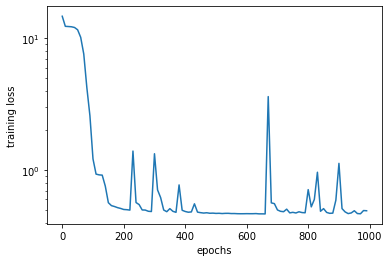

In [92]:
import matplotlib.pyplot as plt
x_lst = list(range(0, 1000, 10))
plt.plot(x_lst, total_loss_lst)
plt.yscale('log')
plt.xlabel("epochs")
plt.ylabel("training loss")
plt.show()

In [93]:
net.eval()

SimpleRNN(
  (in2hidden): Sequential(
    (0): Linear(in_features=261, out_features=256, bias=True)
  )
  (in2output): Sequential(
    (0): Linear(in_features=261, out_features=5, bias=True)
  )
)

In [105]:
for X, Y in train_dl:
    hidden_state = net.init_hidden()
    for j in range(length):
        output, hidden_state = net(X[:, j], hidden_state)
    print(output[:10])
    m = nn.Softmax(dim = 1)
    print(m(output)[:10])
    print(Y[:10])
    break

tensor([[ -2.4785,  10.6795, -29.7537, -13.4525,  -8.9671],
        [ -2.8479,   9.2362,  -3.9544, -15.7425,  -2.3572],
        [ -4.4779,   8.1171, -30.8979,  -1.5834, -10.5022],
        [ -8.5444,   2.4791,   8.1376,  -5.5507,   0.5613],
        [-10.9735,   0.1292, -25.4456,   9.8268,  -9.6339],
        [-10.4013,  12.6164, -12.2187,  -7.8498, -11.3978],
        [ -1.6965,  -0.3629, -20.5261,   7.5045,  -8.4734],
        [ -3.8124,  -4.8164,  -9.6353,   6.0021,  -2.3333],
        [ -5.2684,   4.2564,  -7.9998,  -2.9044,  -5.1460],
        [ -1.2091,  -3.8901, -34.6399,  12.5897, -14.0428]],
       grad_fn=<SliceBackward>)
tensor([[1.9299e-06, 1.0000e+00, 2.7546e-18, 3.3082e-11, 2.9348e-09],
        [5.6485e-06, 9.9998e-01, 1.8680e-06, 1.4186e-11, 9.2261e-06],
        [3.3886e-06, 9.9994e-01, 1.1375e-17, 6.1249e-05, 8.1981e-09],
        [5.6670e-08, 3.4738e-03, 9.9601e-01, 1.1311e-06, 5.1042e-04],
        [9.2578e-10, 6.1425e-05, 4.8011e-16, 9.9994e-01, 3.5342e-09],
        [1.0082e-

In [106]:
states, obs = generate_HMM_sequences(trans_mat, obs_mat, stat_dist, length, num_samples) # generate sample sequences

pos = np.random.randint(length, size = num_samples)

print("transition matrix:")
print(trans_mat)
print("observation matrix:")
print(obs_mat)
print("stationary distribution:")
print(stat_dist)
print("states and observations, first half of each row is states, only showing first 5:")
print(np.concatenate((states, obs), axis = 1)[:5])
print("positions, only showing first 5: ", pos[:5])
h, x, hh = x_i_conditional_prob(trans_mat, obs_mat, stat_dist, obs, pos)
print("Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(h[:5])
print("Pr[X_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(x[:5])
print("Pr[H_i|x_i,x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(hh[:5])

transition matrix:
[[0.19038151 0.5603291  0.24928939]
 [0.59211519 0.37810341 0.0297814 ]
 [0.52737761 0.34205379 0.1305686 ]]
observation matrix:
[[2.84422161e-01 2.51497236e-01 1.31816210e-02 4.38026768e-01
  1.28722143e-02]
 [1.50940815e-01 6.59969385e-01 1.64551320e-02 2.15946003e-02
  1.51040067e-01]
 [9.01408117e-03 9.45219115e-01 4.57668030e-02 7.87716140e-11
  4.61558184e-10]]
stationary distribution:
[0.41619456 0.44908825 0.1347172 ]
states and observations, first half of each row is states, only showing first 5:
[[1. 0. 2. 2. 0. 0. 2. 2. 0. 1. 4. 3. 1. 1. 3. 1. 1. 1. 3. 4.]
 [2. 1. 0. 0. 2. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 4. 4. 1. 4. 0.]
 [1. 0. 0. 1. 2. 1. 1. 1. 1. 0. 1. 0. 3. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 3. 1. 1. 3. 1. 1. 0. 1. 3.]
 [1. 0. 1. 0. 1. 1. 0. 0. 1. 2. 4. 3. 0. 1. 0. 1. 1. 0. 2. 1.]]
positions, only showing first 5:  [0 6 9 3 5]
Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:
[[0.20310978 0.62881966 

In [107]:
obs = obs.astype('long')

In [108]:
pre_obs, labels = obs[:, :-1], obs[:, -1]

In [109]:
features = np.zeros((num_samples, length, num_obs))

In [110]:
for i in range(num_samples):
    for j in range(length - 1):
        features[i, j, pre_obs[i, j]] = 1

In [114]:
test_dataset = data.TensorDataset(torch.FloatTensor(features), torch.LongTensor(labels))
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [133]:
total_loss = 0
num_correct = 0
for X, Y in test_dl:
    hidden_state = net.init_hidden()
    for j in range(length):
        output, hidden_state = net(X[:, j], hidden_state)
    l = loss(output, Y)
    total_loss += l
    #m = nn.Softmax(dim = 1)
    #print(m(output)[:1])
    #print(Y[:1])
    tmp = torch.argmax(output, dim = 1)
    num_correct += torch.sum((tmp == Y))
print(total_loss)
print(num_correct.float() / num_samples)

tensor(54.8504, grad_fn=<AddBackward0>)
tensor(0.3930)
